# SOM


In [365]:
import numpy as np

class Neuron:
    def __init__(self, x, y, length):
        self.x = x
        self.y = y
        self.length = length
        self.nf = 100.
        self.w = [np.random.uniform(-1,10) for i in range(self.length)]
        self.lr = 0.01
        self.decay = 0.000001
        print self.x, self.y, self.w
        
    def distance(self, example):
        return np.sqrt(np.sum((self.w-example)**2))        
        
    def gauss(self, win, it):
        r2 = (win.x-self.x)**2+(win.y-self.y)**2
        sigma = 1 #self.gain(it)
        A = 1/(2.0*np.pi*sigma**2)
        g = A*np.exp(-r2/(2.0*sigma**2))
        #print self.x, self.y, win.x, win.y, g
        return g
    
    def gain(self, it):
        return np.exp(-it/self.nf)
        
    def learningRate(self, it):
        self.lr -= self.decay
        #return 0.001*np.exp(-it/100.0)
        return self.lr
                       
    def update(self, example, win, it):      
        lr = self.learningRate(it)
        gg = self.gauss(win, it)        
        
        dw = np.zeros(2)
        #if(self.x == win.x and self.y == win.y):
        dw = lr*gg*(example-self.w)
        self.w += dw
        return np.sum(dw**2)


0 1 [3.7984369928207355, 0.9088476705736059]


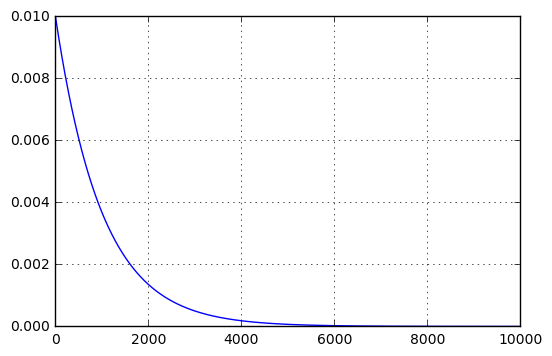

In [366]:
n = Neuron(0, 1, 2)
x = np.arange(0, 10000)
y = 0.01*np.exp(-x/1000.)

import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y, c='b')

plt.grid(True)

In [367]:
class SOM:
    def __init__(self, dim, length):
        self.dim = dim
        self.length = length
        #self.neurons = [[Neuron(i,j, self.length) for j in range(self.dim)] for i in range(self.dim)]        
        self.neurons = []
        for i in range(self.dim):
            el = []
            for j in range(self.dim):
                neuron = Neuron(i, j, self.length)
                el.append(neuron)
            self.neurons.append(el)        
    
    def model(self):
        ret = []
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                ret.append(np.array(neuron.w))
        return np.array(ret)
        
    
    def debug(self):
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                print i, j, neuron.w
        
    def winner(self, example):
        retVal = self.neurons[0][0]
        _min = retVal.distance(example)
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                d = neuron.distance(example)
                if d<_min:
                    _min = d
                    retVal = neuron
        return retVal
    
    def update(self, example, it):
        error = 0
        winner = self.winner(example)
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                error += neuron.update(example, winner, it)
        return error/float(self.dim**2)
                        
    
    def fit(self, examples):
        ret = []
        maxerr = 0.00001
        blok = 100
        for it in range(1000):
            err = 0
            n = 10
            for i in range(n):
                el = random.choice(examples)
                err += self.update(el, it)
            err = err/float(n)
            #if err<maxerr:
            #    print '---- obucen -----'+str(it)+'  '+str(err)
            #    break
            print '---- err -----'+str(it)+'  '+str(err)
            ret.append(self.model())
        return np.array(ret)


In [368]:
import random

_examples = [[0,0], [10,10], [0,10], [10,0]]
examples = []

for el in _examples:
    for r in range(20):
        da = random.uniform(-2, 2)
        db = random.uniform(-1, 1)
        examples.append([el[0]+da, el[1]+db])

examples = np.array(examples)

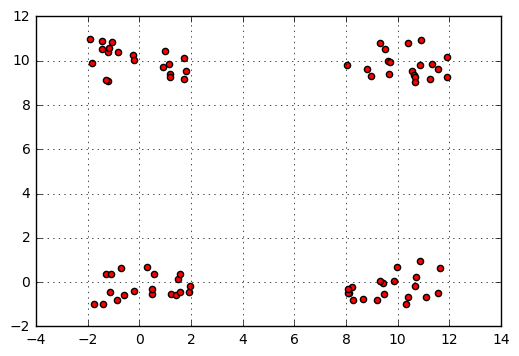

In [369]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(examples[:,0], examples[:,1], c='r')

plt.grid(True)


In [377]:
som = SOM(2, 2)

0 0 [-0.883386032615866, 0.17956581490624401]
0 1 [1.3150563157471726, 6.888445257150845]
1 0 [1.5920033238376652, 8.236154959385495]
1 1 [4.188355181963882, 9.99157274815836]


In [378]:
tr = som.fit(examples)

---- err -----0  9.72161090792e-05
---- err -----1  8.45594506943e-05
---- err -----2  9.9753299348e-05
---- err -----3  5.25091451629e-05
---- err -----4  6.30422887808e-05
---- err -----5  7.69956795379e-05
---- err -----6  7.4431810586e-05
---- err -----7  9.2401378234e-05
---- err -----8  4.80561550529e-05
---- err -----9  5.46930356467e-05
---- err -----10  7.02326727082e-05
---- err -----11  6.74619975372e-05
---- err -----12  5.63437354971e-05
---- err -----13  5.20255673409e-05
---- err -----14  6.54145581981e-05
---- err -----15  7.93388063613e-05
---- err -----16  7.86723838016e-05
---- err -----17  6.22434715618e-05
---- err -----18  7.75119149376e-05
---- err -----19  6.65650109579e-05
---- err -----20  8.39640097931e-05
---- err -----21  7.65364368864e-05
---- err -----22  6.03589745978e-05
---- err -----23  6.1561237092e-05
---- err -----24  8.02257622915e-05
---- err -----25  6.08882157616e-05
---- err -----26  7.3196789728e-05
---- err -----27  5.72582528801e-05
---- er

In [379]:
som.debug()

model = som.model()

print tr.shape

0 0 [ 3.84810273  3.48612753]
0 1 [ 6.05987793  3.65560756]
1 0 [ 3.82706446  5.99589774]
1 1 [ 6.1817362   6.13620692]
(1000, 4, 2)


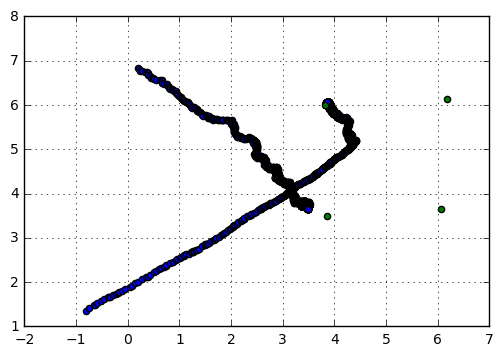

In [381]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

#plt.scatter(examples[:,0], examples[:,1], c='r')
plt.scatter(tr[:,0], tr[:,1], c='b')
plt.scatter(model[:,0], model[:,1], c='g')

plt.grid(True)